# DATA 512 A1 Assignment

Frank Chen

This code is made available for re-use under a [CC0 license](https://creativecommons.org/share-your-work/public-domain/cc0/).

## Step 1: Data Acquisition

I first load the relevant libraries used in this assignment.

In [1]:
import json
import requests
import pandas as pd
import copy as cp
import matplotlib.pyplot as plt
import numpy as np

from pandas.io.json import json_normalize
from functools import reduce

%matplotlib inline 
# to use it in jupyter notebooks

Next, I set up the endpoints, and parameters for the API calls.

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [3]:
# Desktop Params Legacy
desktop_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : "2016070100"
                    }
# Mobile Params Legacy
mobile_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : "2016070100"
                    }

# Desktop Params
desktop_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2019081000'
                        }
# Mobile Web Params
mobile_web_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2019081000'
                        }

# Mobile App Params
mobile_app_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2019081000'
                        }

# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/kfrankc',
    'From': 'kfrankc@uw.edu'
}

In [4]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

Next, I save each API call into a JSON file, with a total of 5 files.

In [5]:
pagecounts_desktop_site = api_call(endpoint_legacy, desktop_params_legacy)
with open('pagecounts_desktop-site_200712-201607.json', 'w') as outfile:
    json.dump(pagecounts_desktop_site, outfile)

In [6]:
pagecounts_mobile_site = api_call(endpoint_legacy, mobile_params_legacy)
with open('pagecounts_mobile-site_200712-201607.json', 'w') as outfile:
    json.dump(pagecounts_mobile_site, outfile)

In [7]:
pageviews_desktop = api_call(endpoint_pageviews, desktop_params_pageviews)
with open('pageviews_desktop_201507-201908.json', 'w') as outfile:
    json.dump(pageviews_desktop, outfile)

In [8]:
pageviews_mobile_web = api_call(endpoint_pageviews, mobile_web_params_pageviews)
with open('pageviews_mobile-web_201507-201908.json', 'w') as outfile:
    json.dump(pageviews_mobile_web, outfile)

In [9]:
pageviews_mobile_app = api_call(endpoint_pageviews, mobile_app_params_pageviews)
with open('pageviews_mobile-app_201507-201908.json', 'w') as outfile:
    json.dump(pageviews_mobile_app, outfile)

## Step 2: Data Processing

In this step, I first load in my JSON files as pandas dataframes. Manipulating/transforming data is easier in dataframes than in pure JSON.

In [10]:
pagecounts_desktop_site_pd = json_normalize(pagecounts_desktop_site['items'])
pagecounts_mobile_site_pd = json_normalize(pagecounts_mobile_site['items'])
pageviews_desktop_pd = json_normalize(pageviews_desktop['items'])
pageviews_mobile_web_pd = json_normalize(pageviews_mobile_web['items'])
pageviews_mobile_app_pd = json_normalize(pageviews_mobile_app['items'])

Next, I create `pagecounts_all_pd` dataframe to store all pagecounts via merging desktop and mobile pagecounts.

In [11]:
pagecounts_mobile_site_pd = pagecounts_mobile_site_pd.drop(['access-site', 'granularity', 'project'], axis=1)
pagecounts_all_pd = pd.merge(pagecounts_desktop_site_pd, pagecounts_mobile_site_pd, on=['timestamp'], how='outer')

In [12]:
# Generate all pagecounts
pagecounts_all_pd['views'] = pagecounts_all_pd['count_x'].add(pagecounts_all_pd['count_y'], fill_value=0)
pagecounts_all_pd = pagecounts_all_pd.drop(['count_x','count_y'], axis=1)

Next, I create `pageviews_mobile_all_pd` dataframe to store all mobile counts (web + app), then merge that with desktop to get `pageviews_all_pd`

In [13]:
# Generate all mobile pageviews
pageviews_mobile_all_pd = cp.deepcopy(pageviews_mobile_web_pd)
pageviews_mobile_all_pd['views'] = pageviews_mobile_web_pd['views'] + pageviews_mobile_app_pd['views']

In [14]:
# Generate all pageviews
pageviews_all_pd = cp.deepcopy(pageviews_mobile_all_pd)
pageviews_all_pd['views'] = pageviews_mobile_all_pd['views'] + pageviews_desktop_pd['views']

Next, I format the timestamp field into datetime, which makes it easier to extract years and months.

In [15]:
pagecounts_desktop_site_pd['timestamp'] = pd.to_datetime(pagecounts_desktop_site_pd['timestamp'], format='%Y%m%d%H')
pagecounts_mobile_site_pd['timestamp'] = pd.to_datetime(pagecounts_mobile_site_pd['timestamp'], format='%Y%m%d%H')
pagecounts_all_pd['timestamp'] = pd.to_datetime(pagecounts_all_pd['timestamp'], format='%Y%m%d%H')
pageviews_desktop_pd['timestamp'] = pd.to_datetime(pageviews_desktop_pd['timestamp'], format='%Y%m%d%H')
pageviews_mobile_all_pd['timestamp'] = pd.to_datetime(pageviews_mobile_all_pd['timestamp'], format='%Y%m%d%H')
pageviews_all_pd['timestamp'] = pd.to_datetime(pageviews_all_pd['timestamp'], format='%Y%m%d%H')

In [16]:
pagecounts_desktop_site_pd['year'] = pagecounts_desktop_site_pd['timestamp'].dt.year
pagecounts_desktop_site_pd['month'] = pagecounts_desktop_site_pd['timestamp'].dt.month
pagecounts_mobile_site_pd['year'] = pagecounts_mobile_site_pd['timestamp'].dt.year
pagecounts_mobile_site_pd['month'] = pagecounts_mobile_site_pd['timestamp'].dt.month
pagecounts_all_pd['year'] = pagecounts_all_pd['timestamp'].dt.year
pagecounts_all_pd['month'] = pagecounts_all_pd['timestamp'].dt.month

pageviews_desktop_pd['year'] = pageviews_desktop_pd['timestamp'].dt.year
pageviews_desktop_pd['month'] = pageviews_desktop_pd['timestamp'].dt.month
pageviews_mobile_all_pd['year'] = pageviews_mobile_all_pd['timestamp'].dt.year
pageviews_mobile_all_pd['month'] = pageviews_mobile_all_pd['timestamp'].dt.month
pageviews_all_pd['year'] = pageviews_all_pd['timestamp'].dt.year
pageviews_all_pd['month'] = pageviews_all_pd['timestamp'].dt.month

Next, I rename the count columns into its respective names detailed in the instructions.

In [17]:
pagecounts_desktop_site_pd['pagecount_desktop_views'] = pagecounts_desktop_site_pd['count']
pagecounts_mobile_site_pd['pagecount_mobile_views'] = pagecounts_mobile_site_pd['count']
pagecounts_all_pd['pagecount_all_views'] = pagecounts_all_pd['views']
pageviews_desktop_pd['pageview_desktop_views'] = pageviews_desktop_pd['views']
pageviews_mobile_all_pd['pageview_mobile_views'] = pageviews_mobile_all_pd['views']
pageviews_all_pd['pageview_all_views'] = pageviews_all_pd['views']

Next, I remove irrelevant columns, and use a lambda function to merge all these dataframes into a single one.

In [18]:
pagecounts_desktop_site_pd = pagecounts_desktop_site_pd.drop(['access-site', 'count', 'granularity', 'project', 'timestamp'], axis=1)
pagecounts_mobile_site_pd = pagecounts_mobile_site_pd.drop(['count', 'timestamp'], axis=1)
pagecounts_all_pd = pagecounts_all_pd.drop(['access-site', 'granularity', 'project', 'timestamp'], axis=1)
pageviews_desktop_pd = pageviews_desktop_pd.drop(['access', 'agent', 'granularity', 'project', 'timestamp', 'views'], axis=1)
pageviews_mobile_all_pd = pageviews_mobile_all_pd.drop(['access', 'agent', 'granularity', 'project', 'timestamp', 'views'], axis=1)
pageviews_all_pd = pageviews_all_pd.drop(['access', 'agent', 'granularity', 'project', 'timestamp', 'views'], axis=1)

In [19]:
# Merge all dataframes
all_pd = reduce(lambda x,y: pd.merge(x,y, on=['year', 'month'], how='outer'), [pagecounts_desktop_site_pd, \
                                                                      pagecounts_mobile_site_pd, \
                                                                      pagecounts_all_pd, \
                                                                      pageviews_desktop_pd, \
                                                                      pageviews_mobile_all_pd, \
                                                                      pageviews_all_pd])

Lastly, I remove an irrelevant column, fill the NA cells with 0, and write to a CSV file.

In [20]:
all_pd = all_pd.drop(['views'], axis=1)

In [21]:
all_pd = all_pd.fillna(0)

In [22]:
all_pd.to_csv('en-wikipedia_traffic_200712-201809.csv', index=False)

## Step 3: Analysis

First, I load in the CSV file into a pandas dataframe. Then, I convert the year and month columns into a `Timestamp` field that can be plotted. Additionally, I created two dataframes from the initial dataframe I loaded in so that I can plot the lines with same colors and distinguish new definitions using dotted lines.

In [23]:
# Read csv
wiki_data = pd.read_csv('en-wikipedia_traffic_200712-201809.csv')

In [24]:
# Set timestamp field
wiki_data['Timestamp'] = pd.to_datetime(wiki_data[['year', 'month']].assign(DAY=1))
wiki_data = wiki_data.drop(['year', 'month'], axis=1)

In [25]:
# Create two dataframes for plotting
wiki_data_1 = wiki_data[['pagecount_desktop_views', 'pagecount_mobile_views', 'pagecount_all_views', 'Timestamp']].copy()
wiki_data_2 = wiki_data[['pageview_desktop_views', 'pageview_mobile_views', 'pageview_all_views', 'Timestamp']].copy()

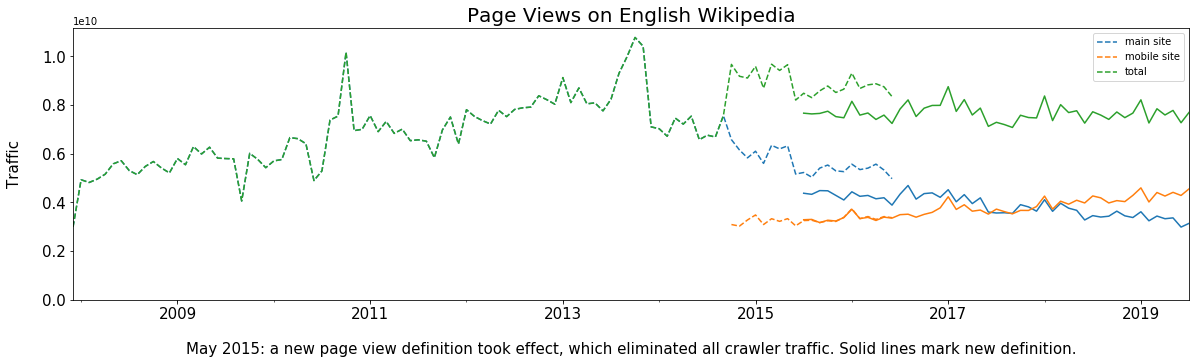

In [26]:
# multiple line plot
ax = wiki_data_1.replace(0, np.nan).plot(x='Timestamp', figsize=(20,5), \
                                         linestyle="--", \
                                         fontsize=15)
ax.set_title('Page Views on English Wikipedia', fontsize= 20)
ax.set_ylabel("Traffic", fontsize=15, labelpad=20)
ax.set_ylim(bottom=0)
ax.set_prop_cycle(None)

wiki_data_2.replace(0, np.nan).plot(x='Timestamp', ax=ax)
ax.set_xlabel("May 2015: a new page view definition took effect, which eliminated all crawler traffic. \
Solid lines mark new definition.", fontsize=15, labelpad=20)
ax.legend(["main site", "mobile site", "total"]);